//anaconda/envs/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


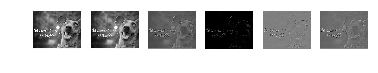

In [1]:
"""
Simple examples of convolution to do some basic filters
Also demonstrates the use of TensorFlow data readers.
We will use some popular filters for our image.
It seems to be working with grayscale images, but not with rgb images.
It's probably because I didn't choose the right kernels for rgb images.
kernels for rgb images have dimensions 3 x 3 x 3 x 3
kernels for grayscale images have dimensions 3 x 3 x 1 x 1
Note:
When you call tf.train.string_input_producer,
a tf.train.QueueRunner is added to the graph, which must be run using
e.g. tf.train.start_queue_runners() else your session will run into deadlock
and your program will crash.
And to run QueueRunner, you need a coordinator to close to your queue for you.
Without coordinator, your threads will keep on running outside session and you will have the error:
ERROR:tensorflow:Exception in QueueRunner: Attempted to use a closed Session.
Author: Chip Huyen
Prepared for the class CS 20SI: "TensorFlow for Deep Learning Research"
cs20si.stanford.edu
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import sys
sys.path.append('..')

from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
import tensorflow as tf

import kernels

FILENAME = 'data/friday.jpg'

def read_one_image(filename):
    """ This is just to demonstrate how to open an image in TensorFlow,
    but it's actually a lot easier to use Pillow 
    """
    filename_queue = tf.train.string_input_producer([filename])
    image_reader = tf.WholeFileReader()
    _, image_file = image_reader.read(filename_queue)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.cast(image, tf.float32) / 256.0 # cast to float to make conv2d work
    return image

def convolve(image, kernels, rgb=True, strides=[1, 3, 3, 1], padding='SAME'):
    images = [image[0]]
    for i, kernel in enumerate(kernels):
        filtered_image = tf.nn.conv2d(image, kernel, strides=strides, padding=padding)[0]
        if i == 2:
            filtered_image = tf.minimum(tf.nn.relu(filtered_image), 255)
        images.append(filtered_image)
    return images

def get_real_images(images):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        images = sess.run(images)
        coord.request_stop()
        coord.join(threads)
    return images

def show_images(images, rgb=True):
    gs = gridspec.GridSpec(1, len(images))
    for i, image in enumerate(images):
        plt.subplot(gs[0, i])
        if rgb:
            plt.imshow(image)
        else: 
            image = image.reshape(image.shape[0], image.shape[1])
            plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

def main():
    rgb = False
    if rgb:
        kernels_list = [kernels.BLUR_FILTER_RGB, kernels.SHARPEN_FILTER_RGB, kernels.EDGE_FILTER_RGB, 
                    kernels.TOP_SOBEL_RGB, kernels.EMBOSS_FILTER_RGB]
    else:
        kernels_list = [kernels.BLUR_FILTER, kernels.SHARPEN_FILTER, kernels.EDGE_FILTER, 
                    kernels.TOP_SOBEL, kernels.EMBOSS_FILTER]

    image = read_one_image(FILENAME)
    if not rgb:
        image = tf.image.rgb_to_grayscale(image)
    image = tf.expand_dims(image, 0) # to make it into a batch of 1 element
    images = convolve(image, kernels_list, rgb)
    images = get_real_images(images)
    show_images(images, rgb)

if __name__ == '__main__':
    main()